In [89]:
import numpy as np
import matplotlib.pyplot as plt
import download
import data_utils

import torch
from torchvision.utils import make_grid

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

seed = 1234
np.random.seed(seed)


In [54]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

Data has apparently already been downloaded and unpacked.


In [55]:
cifar10_dir = './data/cifar-10-batches-py'
X_tr, y_tr, X_te, y_te = data_utils.load_CIFAR10(cifar10_dir)
# train dataset = 50k, test dataset = 10k by default
X_train.shape

(50000, 32, 32, 3)

In [56]:
# split so val dataset = 5k (10% of training), tr set = 45k
val_size = 5000
X_val, y_val = X_tr[:val_size], y_tr[:val_size]
X_tr, y_tr   = X_tr[val_size:], y_tr[val_size:]

print('training set shape: ', X_tr.shape)
print('training labels shape: ', y_tr.shape)
print('validation set shape: ', X_val.shape)
print('validation labels shape: ', y_val.shape)
print('test set shape: ', X_te.shape)
print('test labels shape: ', y_te.shape)

training set shape:  (45000, 32, 32, 3)
training labels shape:  (45000,)
validation set shape:  (5000, 32, 32, 3)
validation labels shape:  (5000,)
test set shape:  (10000, 32, 32, 3)
test labels shape:  (10000,)


In [57]:
# classes = dataset.classes
# print(f'-- {len(classes)} classes: ', classes)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

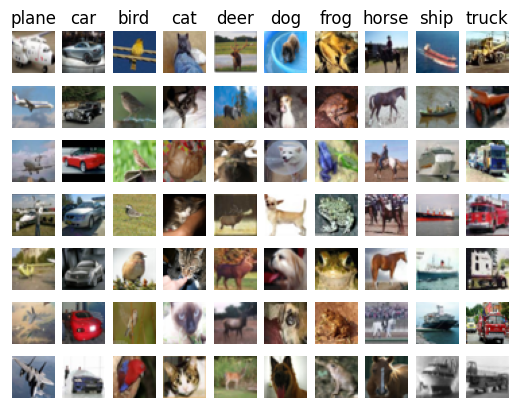

In [111]:
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# images = X_tr[:10]
# for i, img in enumerate(images):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(img.astype('uint8'))
#     plt.axis('off')


In [59]:
# reshape (n, 32, 32, 3) into (n, 3072) for classifier
X_tr = np.reshape(X_tr, (X_tr.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_te = np.reshape(X_te, (X_te.shape[0], -1))

In [83]:
# create minibatches for partial fitting
def minibatches(indices, batch_size=128):
    for i in range(0, len(indices), batch_size):
        yield indices[i:i+batch_size]

# def create_minibatches(X, y, batch_size=128):
#     num_batches = len(y) // batch_size

#     mini_batches = []
#     start, end = 0, batch_size
#     for i in range(num_batches):    
#         start, end = i*batch_size, (i + 1)*batch_size
#         X_mini = X[start:end]
#         y_mini = y[start:end]
#         mini_batches.append((X_mini, y_mini))
    
#     # for leftover data
#     if len(y) % batch_size != 0:
#         start, end = num_batches*batch_size, len(y)
#         X_mini = X[start:end]
#         y_mini = y[start:end]
#         mini_batches.append((X_mini, y_mini))
    
#     return mini_batches

In [84]:
import random
# train/fit on minibatches
def train(logreg, X_tr, y_tr, X_te, y_te, classes=labels, display=True):
    tr_accs, te_accs = [], []

    temp_size = 0
    num_printed = 1
        
#     tr_minibatches = create_minibatches(X_tr, y_tr)
    
    # shuffle data
    shuffledRange = list(range(len(y_tr)))
    random.shuffle(shuffledRange)
    shuffledX = [X_tr[i] for i in shuffledRange]
    shuffledY = [y_tr[i] for i in shuffledRange]
    
    # get batches, fit, predict, find accuracies
    batch_size = 128
    for batch in minibatches(list(range(len(shuffledY))), batch_size):
        X_tr_mini, y_tr_mini = shuffledX[batch[0]:batch[-1]+1], shuffledY[batch[0]:batch[-1]+1]
        logreg.partial_fit(X_tr_mini, y_tr_mini, classes=classes)

        y_pred_tr = logreg.predict(X_tr)
        y_pred_te = logreg.predict(X_te)

        tr_acc = accuracy_score(y_tr, y_pred_tr)
        te_acc = accuracy_score(y_te, y_pred_te)
        
        tr_accs.append(tr_acc)
        te_accs.append(te_acc)
        
        temp_size += len(y_tr_mini)
        if display and (temp_size >= 5000):
            print(f'parsed ~{temp_size*num_printed}, accuracy = train: {tr_acc}, test: {te_acc}')
            temp_size = 0
            num_printed += 1
    
    return tr_accs, te_accs

# train/fit over epochs
def train_epochs(epochs, logreg, X_tr, y_tr, X_te, y_te, classes=labels):
    print('--- Training Logistic Model...')
    
    epoch_tr_accs, epoch_te_accs = [], []
    
    for epoch in range(epochs):
        tr_accs, te_accs = train(logreg, X_tr, y_tr, X_te, y_te)
        
        y_pred_tr = logreg.predict(X_tr)
        y_pred_te = logreg.predict(X_te)

        tr_acc = accuracy_score(y_tr, y_pred_tr)
        te_acc = accuracy_score(y_te, y_pred_te)
        
        epoch_tr_accs.append(epoch_tr_acc)
        epoch_te_accs.append(epoch_te_acc)
        
        print('-------------------------')
        print(f'Epoch [{epoch + 1}/{epochs}] done.')
        print(f'Training Accuracy: {epoch_tr_acc}, Testing Accuracy: {epoch_te_acc}')
        print('-------------------------')
    
    print('--- Training Complete.')
    return epoch_tr_accs, epoch_te_accs


In [85]:
# # Logistic Regression with SGD
# logreg = SGDClassifier(loss='log_loss')
# epochs = 15
# epoch_tr_accs, epoch_te_accs = train_epochs(epochs, logreg, X_tr, y_tr, X_te, y_te, classes=labels)

--- Training Logistic Model...
parsed ~5120, accuracy = train: 0.18124444444444446, test: 0.1823
parsed ~10240, accuracy = train: 0.22806666666666667, test: 0.2251
parsed ~15360, accuracy = train: 0.225, test: 0.2208
parsed ~20480, accuracy = train: 0.2861111111111111, test: 0.276
parsed ~25600, accuracy = train: 0.2590222222222222, test: 0.2508
parsed ~30720, accuracy = train: 0.21644444444444444, test: 0.2019
parsed ~35840, accuracy = train: 0.27268888888888887, test: 0.2617
parsed ~40960, accuracy = train: 0.23128888888888888, test: 0.2237
-------------------------
Epoch [1/15] done.
Training Accuracy: 0.2802222222222222, Testing Accuracy: 0.2668
-------------------------
parsed ~5120, accuracy = train: 0.21144444444444443, test: 0.2059
parsed ~10240, accuracy = train: 0.2923777777777778, test: 0.2831
parsed ~15360, accuracy = train: 0.2533111111111111, test: 0.2394
parsed ~20480, accuracy = train: 0.22297777777777777, test: 0.2152
parsed ~25600, accuracy = train: 0.1525333333333333

parsed ~30720, accuracy = train: 0.2704666666666667, test: 0.2334
parsed ~35840, accuracy = train: 0.209, test: 0.1942
parsed ~40960, accuracy = train: 0.26797777777777776, test: 0.245
-------------------------
Epoch [13/15] done.
Training Accuracy: 0.2991111111111111, Testing Accuracy: 0.2661
-------------------------
parsed ~5120, accuracy = train: 0.29746666666666666, test: 0.2641
parsed ~10240, accuracy = train: 0.30035555555555554, test: 0.268
parsed ~15360, accuracy = train: 0.27566666666666667, test: 0.238
parsed ~20480, accuracy = train: 0.2312, test: 0.2136
parsed ~25600, accuracy = train: 0.29231111111111113, test: 0.2568
parsed ~30720, accuracy = train: 0.3581111111111111, test: 0.3208
parsed ~35840, accuracy = train: 0.37895555555555555, test: 0.3303
parsed ~40960, accuracy = train: 0.17522222222222222, test: 0.1663
-------------------------
Epoch [14/15] done.
Training Accuracy: 0.15817777777777778, Testing Accuracy: 0.145
-------------------------
parsed ~5120, accuracy =

In [95]:
logreg2 = SGDClassifier(shuffle=True, loss='log_loss', max_iter=100)

print('Training..')
logreg2.fit(X_tr, y_tr)
print('Training Complete.')

y_pred_tr2 = logreg2.predict(X_tr)
y_pred_te2 = logreg2.predict(X_te)

tr_acc2 = accuracy_score(y_tr, y_pred_tr2)
te_acc2 = accuracy_score(y_te, y_pred_te2)

print('Training Accuracy: ', tr_acc2)
print('Testing Accuracy: ', te_acc2)

Training..


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Training Complete.
Training Accuracy:  0.2702222222222222
Testing Accuracy:  0.2295


In [106]:
num_iters = [1,10,20,50,100,500,1000]

iter_val_accs = []
iter_tr_accs = []
iter_te_accs = []

# train on diff max_iters
# find accuracy on validation
# best max_iter value given by highest accuracy seen in validation accuracy graph
for n in num_iters:
    print(f'Training on max_iters={n}...')
    logreg3 = SGDClassifier(shuffle=True, loss='log_loss', max_iter=n)
    logreg3.fit(X_tr, y_tr)
    
    y_pred_val = logreg3.predict(X_val)
    y_pred_tr = logreg3.predict(X_tr)
    y_pred_te = logreg3.predict(X_te)

    val_acc = accuracy_score(y_val, y_pred_val)
    tr_acc = accuracy_score(y_tr, y_pred_tr)
    te_acc = accuracy_score(y_te, y_pred_te)
    
    iter_val_accs.append(val_acc)
    iter_tr_accs.append(tr_acc)
    iter_te_accs.append(te_acc)
    
    print(val_acc)



Training on max_iters=1...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.296
Training on max_iters=10...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.3084
Training on max_iters=20...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.2606
Training on max_iters=50...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.314
Training on max_iters=100...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.1754
Training on max_iters=500...
0.2524
Training on max_iters=1000...
0.2726


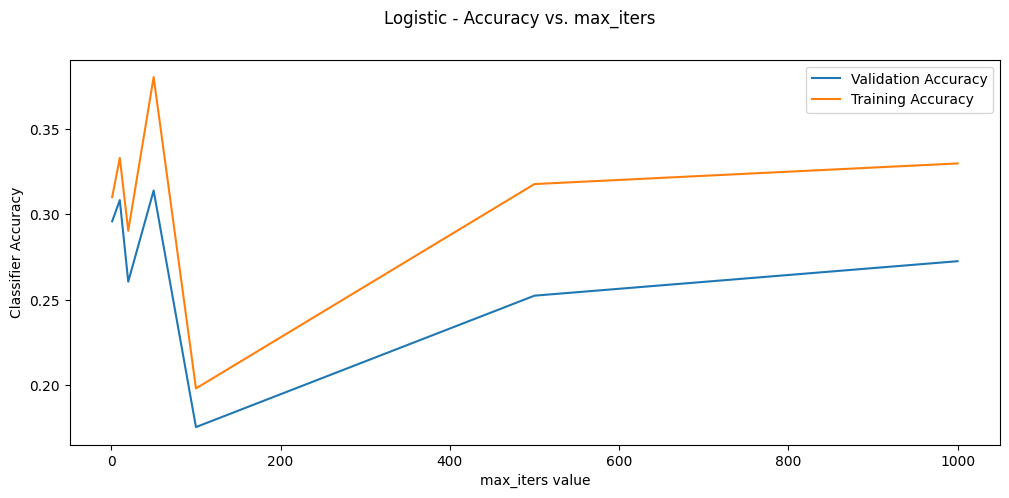

In [110]:
# plotting
fig, axes = plt.subplots(figsize=(12,5))
fig.suptitle('Logistic - Accuracy vs. max_iters')

axes.plot(num_iters, iter_val_accs, label='Validation Accuracy')
axes.plot(num_iters, iter_tr_accs, label='Training Accuracy')
# axes.plot(num_iters, iter_te_accs, label='Testing Accuracy')

axes.set_xlabel('max_iters value')
axes.set_ylabel('Classifier Accuracy')
axes.legend(fontsize=10)

In [116]:
iter_val_accs = np.asarray(iter_val_accs)

best_max_iter_val_index = np.argmax(iter_val_accs)
print(f'Best max_iter value: {num_iters[best_max_iter_val_index]}')
print(f'- with largest seen val accuracy of: {iter_val_accs[best_max_iter_val_index]}')

print('final model testing accuracy: ', iter_te_accs[best_max_iter_val_index])
print('final model training accuracy: ', iter_tr_accs[best_max_iter_val_index])

Best max_iter value: 50
- with largest seen val accuracy of: 0.314
final model testing accuracy:  0.3134
final model training accuracy:  0.3804888888888889


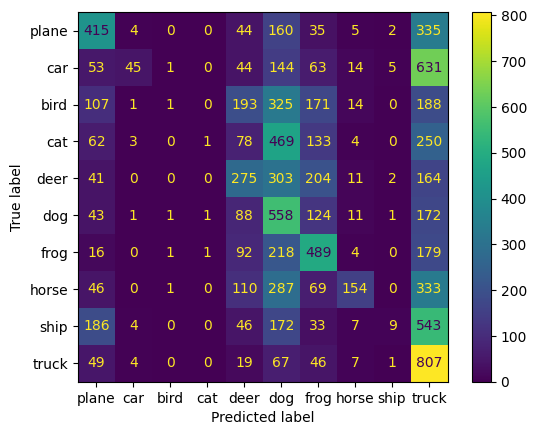

In [90]:
cm = confusion_matrix(y_te, y_pred_te)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_disp.plot()

In [104]:
print(classification_report(y_te, y_pred_te, target_names=classes))

              precision    recall  f1-score   support

       plane       0.41      0.41      0.41      1000
         car       0.73      0.04      0.08      1000
        bird       0.20      0.00      0.00      1000
         cat       0.33      0.00      0.00      1000
        deer       0.28      0.28      0.28      1000
         dog       0.21      0.56      0.30      1000
        frog       0.36      0.49      0.41      1000
       horse       0.67      0.15      0.25      1000
        ship       0.45      0.01      0.02      1000
       truck       0.22      0.81      0.35      1000

    accuracy                           0.28     10000
   macro avg       0.38      0.28      0.21     10000
weighted avg       0.38      0.28      0.21     10000

